In [1]:
import tensorflow as tf
import numpy as np

from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.misc import  imresize

from tensorflow import keras
from keras.datasets import fashion_mnist

from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Layer,Lambda,InputLayer
from tensorflow.keras.layers import Resizing, Rescaling
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

import cvnn.layers as complex_layers

import warnings
warnings.filterwarnings('ignore')

print(tf.__version__)
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.8.0


In [2]:
# python == 3.7
# tenorflow == 2.8.0
# scipy==1.1.0

### 1.Define phase object ( Preprocess the images with up-sampling )
1. Load image that serves as phase object  

2. Image is 28x28 pixels, and is padded to 200x200 pixels  with 0's  

3. Phase Image = exp(2$\pi$ i * Padded Image)

The digital image is encoded in phasor form, with an uniform amplitude and different phase angle.


In [3]:
def preprocess(image,target_size = 200):
    
    original_size = 28
    target_size = target_size
    up_sampling_size = 84
    
    up_sampling_image = imresize(image.reshape(28,28),(up_sampling_size,up_sampling_size),interp="nearest")
    phase_image_padded = np.pad(up_sampling_image,   # pad the phase image with 0's
                                int((target_size-up_sampling_size)/2),
                                mode='constant',constant_values=0)

    phase_image = np.exp(1j*2.0*np.pi*phase_image_padded)   # convert to phase image
    return phase_image      

In [4]:
size = 200              # size of the resultant image
num_train = 8
num_test = 2

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images, train_labels = train_images[0:num_train], train_labels[0:num_train]

test_images, test_labels = test_images[0:num_test], test_labels[0:num_test]

train_labels, test_labels = to_categorical(train_labels, 10), to_categorical(test_labels,10)

temp_train = [] 
for i in range(len(train_images)):
    temp_train.append(preprocess(train_images[i],size))
train_images = temp_train

temp_test = [] 
for i in range(len(test_images)):
    temp_test.append(preprocess(test_images[i],size))
test_images = temp_test

train_images, test_images = tf.cast(train_images,dtype=tf.complex64), tf.cast(test_images,dtype=tf.complex64)
# print(train_images)

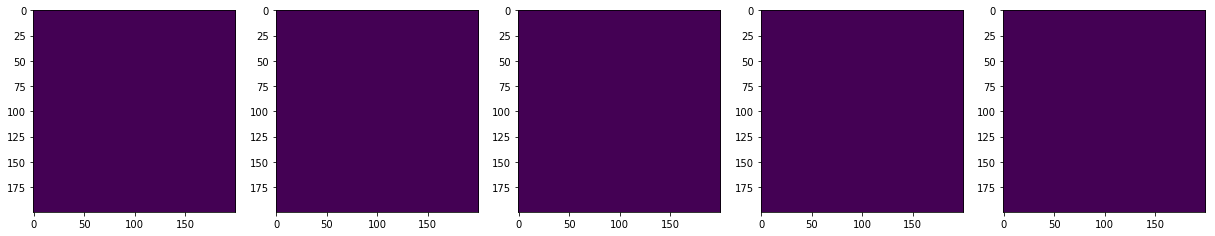

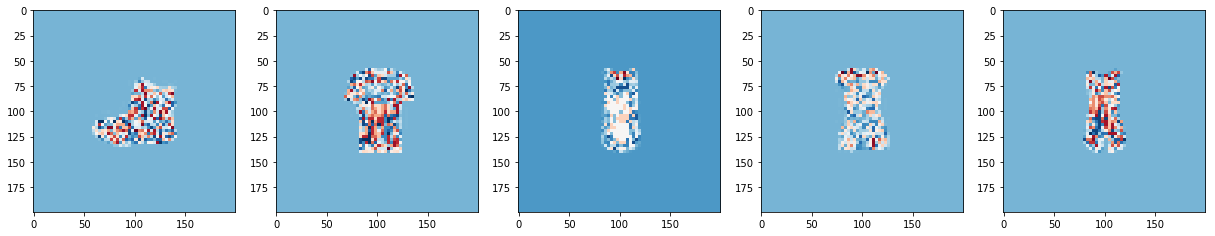

In [5]:
# plot the amplitude of the phase images
rows, cols = 1 ,5
fig = plt.figure(figsize=(21,8))
for i in range(5):
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(np.abs(train_images[i]))   

# # plot the phase(angle) of the phase images
rows, cols = 1 ,5
fig = plt.figure(figsize=(21,8))
for i in range(5):
    fig.add_subplot(rows,cols,i+1)
    plt.imshow(np.angle(train_images[i]),cmap='RdBu')

### 2.Build the Diffraction layer using Angular Spectrum method

### Angular Spectrum Propagation
$$U_1(x,y) =\mathcal{F}^{-1}[\mathcal{F} U_0(x,y)\mathcal{F}h(x,y)]$$

$$U_1(x,y) =\mathcal{F}^{-1}[\mathcal{F} U_0(x,y) H(f_x,f_y)]$$


This can be described using Fourier transforms.The first Fourier transform decomposes the initial field into plane waves. To propagate the plane waves, we multiply each wave by a complex phase factor, and then we take the inverse Fourier transform to add all the propagated plane waves back together.

To implement Angular spectrum propagation, the Fouier transform of the initial field is first multiplied with the phase factor $$H=e^{ik_zz}$$, where $k_z$is a function of the spatial frequencies $$k_z=\sqrt{k^2-k_x^2-k_y}$$where $$  k = \frac{2\pi}{\lambda}$$ and $k_x$ and $k_y$ are related to the spatial frequencies $f_x$ and $f_y$ by a factor of $2\pi$ $$k_{x,y} = 2\pi f_{x,y}$$

Hence the complex exponential can be written in terms of the Fourier coordinates $f_x$ and $f_y$, that is 

$$H=e^{ik_zz},k_z = 2\pi \sqrt{\frac{1}{\lambda}-f_x-f_y}$$

Descretized spatial freqnency $f_x = k*\Delta f = \frac{k}{N \Delta x}$  
Interval between the spatial frequencies $\Delta f = \frac{1}{N \Delta x}=\frac{1}{L}$,where $L$ denotes the field of view in object space

In [14]:
class Diffraction_Layer(Layer):
    def __init__(self, units =200):
        '''Initialize the diffraction layer attributes'''
        super(Diffraction_Layer, self).__init__()
        self.units = units
        
        # Define system parameters
        self.N = self.units                                         # field array size
        self.L = 0.08                                               # source and observation plane side length, field of view
        self.dx = self.L/ self.N                                    # sampling interval in space
        self.x = np.arange(-self.L/2,self.L/2,self.dx)
        self.fx = np.arange(-1/(2*self.dx),1/(2*self.dx),1/self.L)
        [self.FX, self.FY] = np.meshgrid(self.fx,self.fx)
        
        self.lmb = 0.4e-3                                          # wavelength of the optical wave
        self.z = 0.03                                              # distance of propagation(the distance bewteen two layers)
        self.k = 2.0*np.pi/self.lmb                                # wave number
        

    def build(self, input_shape):
        '''Create the state of the layer (weights)'''

        weight_init = tf.random_normal_initializer()
        self.weight = tf.Variable(name= "weight",
            initial_value=weight_init(shape=(self.units,self.units), dtype='float32'),
            trainable=True)
        
    @tf.function
    def call(self, inputs):
        '''Define the computation'''
        def angular_spectrum_propagator(u0, z=self.z,k=self.k,FX= self.FX, FY= self.FY):
            kz = np.sqrt(k**2-np.square(2*np.pi*FX)-np.square(2*np.pi*FY))
            H = np.exp(1j*z*kz)
            H = tf.cast(H,dtype=tf.complex64)
            u1 = tf.signal.ifft2d(tf.signal.fft2d(u0)*tf.signal.fftshift(H))
            return u1
        
        return angular_spectrum_propagator(inputs)*tf.cast(self.weight,dtype=tf.complex64)

In [15]:
class Detector(Layer):
    def __init__(self, units=200):
        '''Initialize the instance attributes'''
        super(Detector, self).__init__()
        self.units = units
    
    @tf.function
    def call(self, inputs):
        ''' Converts output to one hot form
        Applies softmax'''
        def rang(arr,shape,size=self.units,base = 200):
            return arr[shape[0]*size//base:shape[1]*size//base,shape[2]*size//self.units:shape[3]*size//self.units]
        
        def reduce_mean(tf_):
            return tf.reduce_mean(tf_)
        
        def _ten_regions(a):
            return tf.map_fn(reduce_mean,tf.convert_to_tensor([
                rang(a,(46,66,46,66)),
                rang(a,(46,66,93,113)),
                rang(a,(46,66,140,160)),
                rang(a,(85,105,46,66)),
                rang(a,(85,105,78,98)),
                rang(a,(85,105,109,129)),
                rang(a,(85,105,140,160)),
                rang(a,(125,145,46,66)),
                rang(a,(125,145,93,113)),
                rang(a,(125,145,140,160))
            ]))
        
        def ten_regions(logits):
            return tf.map_fn(_ten_regions,tf.abs(logits),dtype=tf.float32)

        return tf.square(tf.nn.softmax(ten_regions(tf.abs(inputs)))) # logits_abs

In [16]:
def loss_function(y_label,logits_abs):
    
    return tf.reduce_sum(tf.square(logits_abs-y_label))

In [17]:
def get_D2NN_model():
    inputs = complex_layers.complex_input(shape=(size,size))
    h1 = Diffraction_Layer(size)(inputs)
    h2 = Diffraction_Layer(size)(h1)
    h3 = Diffraction_Layer(size)(h2)
    h4 = Diffraction_Layer(size)(h3)
    h5 = Diffraction_Layer(size)(h4)
    out = Detector()(h5)
    return tf.keras.Model(inputs, out)

D2NN = get_D2NN_model()  

D2NN.summary()
# plot_model(D2NN, show_shapes=True, show_layer_names=True, to_file='D2NN-model.png')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

In [18]:
# Define the traning parameters
learning_rate = 0.01
batch_size = 8
epochs = 2

D2NN.compile(optimizer='adam',
             loss = loss_function,
             metrics=['accuracy'])

checkpoint_path = './Training_results/D2NN_MODEL'
checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             save_weights_only = True,
                             sace_freq = 'epoch')
                            

history = D2NN.fit(train_images, train_labels,
                   epochs=epochs,
                   batch_size = batch_size,
                   validation_data=(test_images, test_labels),
                   callbacks = [checkpoint])

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing th